### A Density Based Scan tool for images. 

#### Lets you input an nxm image to cluster features.

###### Usage: clusters, points, labels = simpleDBSCAN(img, radius = 10, eps = 5)  

>Last updated 11/17/2018 by Shehab Attia

In [3]:
#Import libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time
from skimage import color
%matplotlib inline

In [88]:
#Implementing image DBScan
timekeeper_dictionary = {}
def timekeeper(message = None):
    global timekeeper_dictionary
    if message is None:
        raise Exception("Timekeeper: you must specify a message")
    if message in timekeeper_dictionary:
        print("Took ",(time.time() - timekeeper_dictionary[message])," seconds to run ", message) #Output computing time
        del timekeeper_dictionary[message] #Delete the message
    else:
        timekeeper_dictionary[message] = time.time() #Start tracking time
    
def getDistance(x,y):
    return np.sqrt(x**2 + y**2)
def getNeighboringPoints(points, point, radius):
    x_points = points[:,0] - point[0]
    y_points = points[:,1] - point[1]
    distances = getDistance(x_points,y_points)
    distances = distances.reshape(-1,)
    return np.argwhere((distances<=radius) & (distances>=-radius))#Return indecies that are within acceptable radius.
def computeXYZ(image):
    points = []
    timekeeper("computeXYZ") #Start tracking time
    for row in range(0,image.shape[0]):
        for col in range(0,image.shape[1]):
            points.append((row,col,image[row,col])) #Create a nxn matrix of points for easier computation
    timekeeper("computeXYZ") #Output computing time
    return np.array(points)
def getNeighborsWithinThreshold(points, point, threshold):
    intensity = points[:,2]
    intensity = intensity.reshape(-1,)
    print("Looking for color:",point[2])
    return np.argwhere((intensity<=(threshold+point[2])) & (intensity>=(-threshold+point[2]))) #Return indecies that are within threshold.
# Usage: clusters, points, labels = simpleDBSCAN(img, radius = 10, eps = 5)  
def simpleDBSCAN(image, radius = 10, threshold = 5, max_clusters = 1000):
    timekeeper("simpleDBSCAN") #Start tracking time
    rows,cols = image.shape
    points = computeXYZ(image) #We'll be using indecies of points from now on.
    clusters = [] #Indecies of points in clusters
    labels = np.zeros((rows*cols,1))-1 #Keep track of indecies we're clustering
    while (len(labels[labels<0])>0):
        #display results
        print(labels.reshape((rows,cols)))
        plt.imshow(labels.reshape(rows,cols),cmap='jet')
        plt.show()
        if (len(clusters)>max_clusters):
            raise Exception("Max cluster limit reached")
        unclustered_indecies = np.argwhere(labels<0)[:,0]
        point_index = unclustered_indecies[0]
        print("Number of clusters:",len(clusters), "Current index",point_index, "Points left:", len(unclustered_indecies))
        point = points[point_index]
        neighbors = getNeighboringPoints(points, point, radius) #Find neighbors within radius
        if (len(neighbors)==0):
            clusters.append([point_index]) #No neighbors, start new cluster
            labels[point_index] = len(clusters)
            continue #Move on to the next point
        print("Neighbors in vicinity:",len(neighbors))
        neighbors = np.intersect1d(getNeighborsWithinThreshold(points, point, threshold), neighbors)
        print("Neighbors within threshold:",len(neighbors))
        if (len(neighbors)==0):
            clusters.append([point_index]) #No neighbors, start new cluster
            labels[point_index] = len(clusters)
            continue #Move on to the next point
        #We have neighbors, find the cluster each point belongs to by scoring.
        scores = np.zeros(len(clusters))
        unclustered_neighbors = []
        for cluster_ind in range(0,len(clusters)):
            cluster = clusters[cluster_ind]
            for neighbor in neighbors:
                if  neighbor in cluster:
                    scores[cluster_ind] = scores[cluster_ind] + 1
                elif labels[neighbor]<0:
                    unclustered_neighbors.append(neighbor)
        if len(scores)==0 or (np.max(scores)==0):
            clusters.append([point_index]) #No neighbors, start new cluster
            labels[point_index] = len(clusters)-1
            print("No neighbors")
        else:
            cluster_ind = np.argmax(scores)
            clusters[cluster_ind].append(point_index)
            labels[point_index] = cluster_ind
            #add neighbors too
            for neighbor in unclustered_neighbors:
                clusters[cluster_ind].append(neighbor)
                labels[neighbor] = cluster_ind
            print("Added to cluster ", np.argmax(scores))
    
    plt.imshow(labels.reshape(rows,cols),cmap='jet')
    plt.show()
    timekeeper("simpleDBSCAN") #Output time for dbscan to run
    return clusters, points, labels

# Testing and debugging.

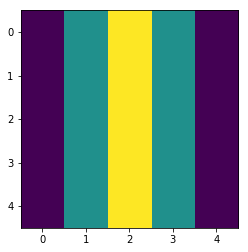

Took  0.0  seconds to run  computeXYZ
[[-1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1.]]


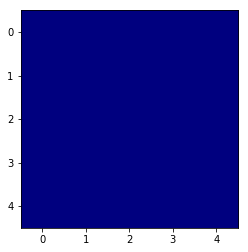

Number of clusters: 0 Current index 0 Points left: 25
Neighbors in vicinity: 25
Looking for color: 0.0
Neighbors within threshold: 10
No neighbors
[[ 0. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1.]]


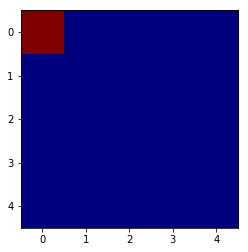

Number of clusters: 1 Current index 1 Points left: 24
Neighbors in vicinity: 25
Looking for color: 10.0
Neighbors within threshold: 10
No neighbors
[[ 0.  1. -1. -1. -1.]
 [-1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1.]]


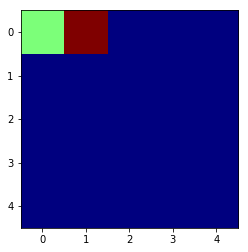

Number of clusters: 2 Current index 2 Points left: 23
Neighbors in vicinity: 25
Looking for color: 20.0
Neighbors within threshold: 5
No neighbors
[[ 0.  1.  2. -1. -1.]
 [-1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1.]]


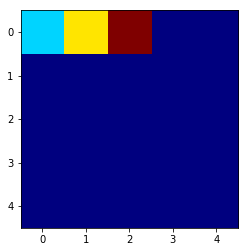

Number of clusters: 3 Current index 3 Points left: 22
Neighbors in vicinity: 25
Looking for color: 10.0
Neighbors within threshold: 10
Added to cluster  1
[[ 0.  1.  2.  1. -1.]
 [-1.  1. -1.  1. -1.]
 [-1.  1. -1.  1. -1.]
 [-1.  1. -1.  1. -1.]
 [-1.  1. -1.  1. -1.]]


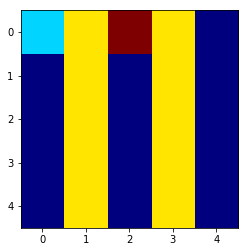

Number of clusters: 3 Current index 4 Points left: 13
Neighbors in vicinity: 25
Looking for color: 0.0
Neighbors within threshold: 10
Added to cluster  0
[[ 0.  1.  2.  1.  0.]
 [ 0.  1. -1.  1.  0.]
 [ 0.  1. -1.  1.  0.]
 [ 0.  1. -1.  1.  0.]
 [ 0.  1. -1.  1.  0.]]


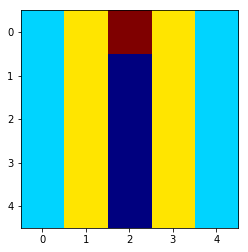

Number of clusters: 3 Current index 7 Points left: 4
Neighbors in vicinity: 25
Looking for color: 20.0
Neighbors within threshold: 5
Added to cluster  2


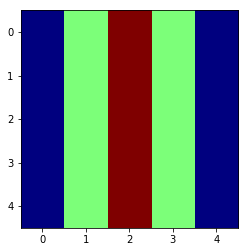

Took  2.487657308578491  seconds to run  simpleDBSCAN
[[0. 1. 2. 1. 0.]
 [0. 1. 2. 1. 0.]
 [0. 1. 2. 1. 0.]
 [0. 1. 2. 1. 0.]
 [0. 1. 2. 1. 0.]]
[[ 0. 10. 20. 10.  0.]
 [ 0. 10. 20. 10.  0.]
 [ 0. 10. 20. 10.  0.]
 [ 0. 10. 20. 10.  0.]
 [ 0. 10. 20. 10.  0.]]


In [89]:
#Test on the blobs dataset
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=5, centers=3, n_features=5)
# plt.scatter(X[:,0],X[:,1],c=y)

img = np.zeros(X.shape[0]*X.shape[0]).reshape(X.shape[0],X.shape[0])
for row in range(0,len(X)):
    for col in range(0,len(X)):
        img[row,col] = y[col]*10
        
plt.imshow(img)
plt.show()
clusters, points,labels = simpleDBSCAN(img, 100, 2)
print(labels.reshape(img.shape))
print(img.reshape(img.shape))

(100, 2) (100,)
(100, 100)


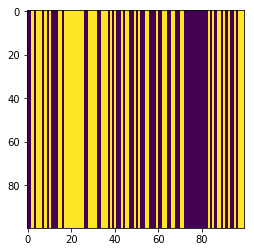

Took  0.009006023406982422  seconds to run  computeXYZ
[[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


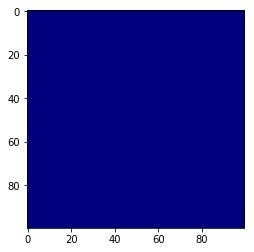

Number of clusters: 0 Current index 0 Points left: 10000
Neighbors in vicinity: 7953
Looking for color: 0.0
Neighbors within threshold: 3888
No neighbors
[[ 0. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


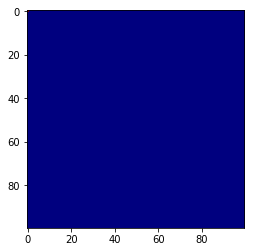

Number of clusters: 1 Current index 1 Points left: 9999
Neighbors in vicinity: 8038
Looking for color: 0.0
Neighbors within threshold: 3930
Added to cluster  0
[[ 0.  0. -1. ... -1. -1. -1.]
 [ 0.  0. -1. ... -1. -1. -1.]
 [ 0.  0. -1. ... -1. -1. -1.]
 ...
 [ 0.  0. -1. ... -1. -1. -1.]
 [ 0.  0. -1. ... -1. -1. -1.]
 [ 0.  0. -1. ... -1. -1. -1.]]


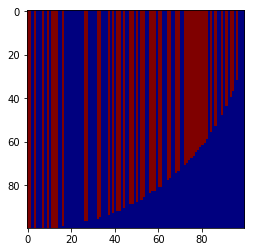

Number of clusters: 1 Current index 2 Points left: 6070
Neighbors in vicinity: 8118
Looking for color: 10.0
Neighbors within threshold: 4146
No neighbors
[[ 0.  0.  1. ... -1. -1. -1.]
 [ 0.  0. -1. ... -1. -1. -1.]
 [ 0.  0. -1. ... -1. -1. -1.]
 ...
 [ 0.  0. -1. ... -1. -1. -1.]
 [ 0.  0. -1. ... -1. -1. -1.]
 [ 0.  0. -1. ... -1. -1. -1.]]


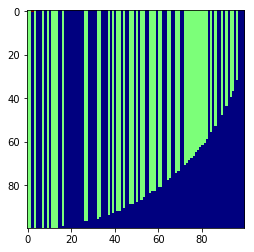

Number of clusters: 2 Current index 4 Points left: 6069
Neighbors in vicinity: 8264
Looking for color: 10.0
Neighbors within threshold: 4218
Added to cluster  1
[[ 0.  0.  1. ...  1.  1.  1.]
 [ 0.  0.  1. ...  1.  1.  1.]
 [ 0.  0.  1. ...  1.  1.  1.]
 ...
 [ 0.  0.  1. ... -1. -1. -1.]
 [ 0.  0.  1. ... -1. -1. -1.]
 [ 0.  0.  1. ... -1. -1. -1.]]


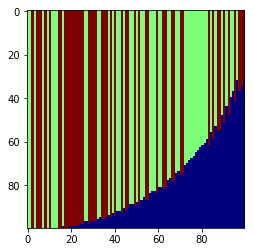

Number of clusters: 2 Current index 3296 Points left: 1852
Neighbors in vicinity: 9617
Looking for color: 0.0
Neighbors within threshold: 4802
Added to cluster  0
[[ 0.  0.  1. ...  1.  1.  1.]
 [ 0.  0.  1. ...  1.  1.  1.]
 [ 0.  0.  1. ...  1.  1.  1.]
 ...
 [ 0.  0.  1. ... -1. -1. -1.]
 [ 0.  0.  1. ... -1. -1. -1.]
 [ 0.  0.  1. ... -1. -1. -1.]]


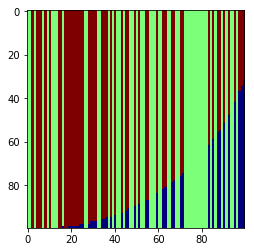

Number of clusters: 2 Current index 3299 Points left: 783
Neighbors in vicinity: 9434
Looking for color: 10.0
Neighbors within threshold: 4727
Added to cluster  1
[[0. 0. 1. ... 1. 1. 1.]
 [0. 0. 1. ... 1. 1. 1.]
 [0. 0. 1. ... 1. 1. 1.]
 ...
 [0. 0. 1. ... 1. 1. 1.]
 [0. 0. 1. ... 1. 1. 1.]
 [0. 0. 1. ... 1. 1. 1.]]


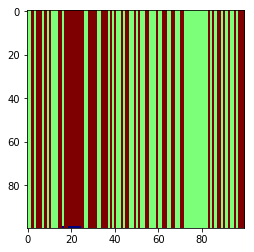

Number of clusters: 2 Current index 9916 Points left: 7
Neighbors in vicinity: 8928
Looking for color: 0.0
Neighbors within threshold: 4404
Added to cluster  0
[[0. 0. 1. ... 1. 1. 1.]
 [0. 0. 1. ... 1. 1. 1.]
 [0. 0. 1. ... 1. 1. 1.]
 ...
 [0. 0. 1. ... 1. 1. 1.]
 [0. 0. 1. ... 1. 1. 1.]
 [0. 0. 1. ... 1. 1. 1.]]


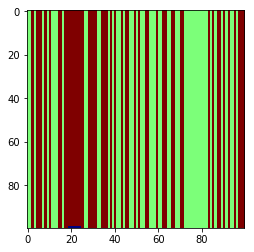

Number of clusters: 2 Current index 9919 Points left: 6
Neighbors in vicinity: 9052
Looking for color: 10.0
Neighbors within threshold: 4577
Added to cluster  1


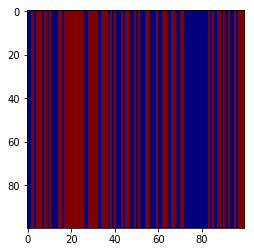

Took  15.552448511123657  seconds to run  simpleDBSCAN
[[0. 0. 1. ... 1. 1. 1.]
 [0. 0. 1. ... 1. 1. 1.]
 [0. 0. 1. ... 1. 1. 1.]
 ...
 [0. 0. 1. ... 1. 1. 1.]
 [0. 0. 1. ... 1. 1. 1.]
 [0. 0. 1. ... 1. 1. 1.]]
[[ 0.  0. 10. ... 10. 10. 10.]
 [ 0.  0. 10. ... 10. 10. 10.]
 [ 0.  0. 10. ... 10. 10. 10.]
 ...
 [ 0.  0. 10. ... 10. 10. 10.]
 [ 0.  0. 10. ... 10. 10. 10.]
 [ 0.  0. 10. ... 10. 10. 10.]]


In [90]:
#Test on the moons dataset
from sklearn.datasets.samples_generator import make_moons
X, y = make_moons(n_samples=100)
# plt.scatter(X[:,0],X[:,1],c=y)
# plt.show()
print(X.shape,y.shape)
img = np.zeros(X.shape[0]*X.shape[0]).reshape(X.shape[0],X.shape[0])
print(img.shape)
for row in range(0,len(X)):
    for col in range(0,len(X)):
        img[row,col] = y[col]*10
        
plt.imshow(img)
plt.show()
clusters, points,labels = simpleDBSCAN(img, 100, 2)
print(labels.reshape(img.shape))
print(img.reshape(img.shape))